In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
import numpy as np
import pandas as pd

In [12]:
!pip install scikit-learn==1.3.2 --force-reinstall



  Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 3.3 MB/s eta 0:00:00a 0:00:01m
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 3.0 MB/s eta 0:00:0000:0100:01
Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl (22.4 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:

In [14]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import spacy
import re

nlp = spacy.load("en_core_web_md")

def spacy_clean(text):
    doc = nlp(text.lower())
    cleaned = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return ' '.join(cleaned)

def final_clean(text):
    text = spacy_clean(text)
    text = re.sub(r'\w*\d\w*', '', text)  # remove words with numbers
    return text

In [4]:
drake_df = pd.read_csv("Drake.csv")
taylor_df = pd.read_csv("TaylorSwift.csv")
beyonce_df = pd.read_csv("Beyonce.csv")

beyonce_df['label'] = 'Beyonce'
drake_df['label'] = 'Drake'
taylor_df['label'] = 'Taylor Swift'

df = pd.concat(
    [drake_df[['Lyric', 'label']], taylor_df[['Lyric', 'label']], beyonce_df[['Lyric', 'label']]],
    ignore_index=True
)
df.dropna(subset=['Lyric'], inplace=True)

# Apply cleaning
df['clean_lyrics'] = df['Lyric'].apply(final_clean)
df[['label', 'clean_lyrics']].sample(5)

,label,clean_lyrics
1214,Beyonce,boy boy boy boy boy boy boy boy boy boy day...
410,Drake,yeah alright paige hope mind hope mind uhm hav...
810,Taylor Swift,search video kanye tell go bitch song exist ...
1138,Beyonce,nala come home need king
1160,Beyonce,north america april miami fl marlin park a...


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_lyrics'], df['encoded_label'], stratify=df['encoded_label'], test_size=0.2, random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Store class names for later use
class_names = le.classes_


Logistic Regression Evaluation
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

     Beyonce       0.89      0.79      0.84        81
       Drake       0.96      0.91      0.93        93
Taylor Swift       0.83      0.95      0.89        96

    accuracy                           0.89       270
   macro avg       0.89      0.88      0.89       270
weighted avg       0.89      0.89      0.89       270



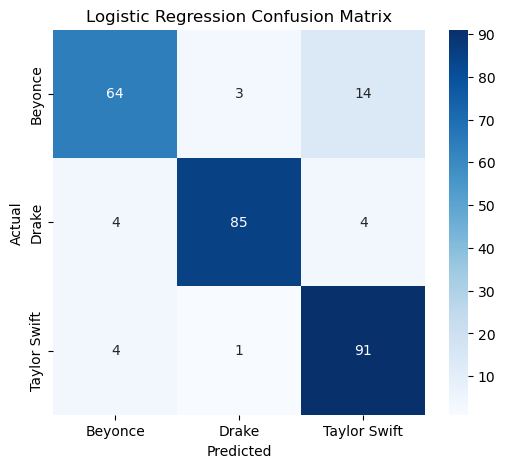

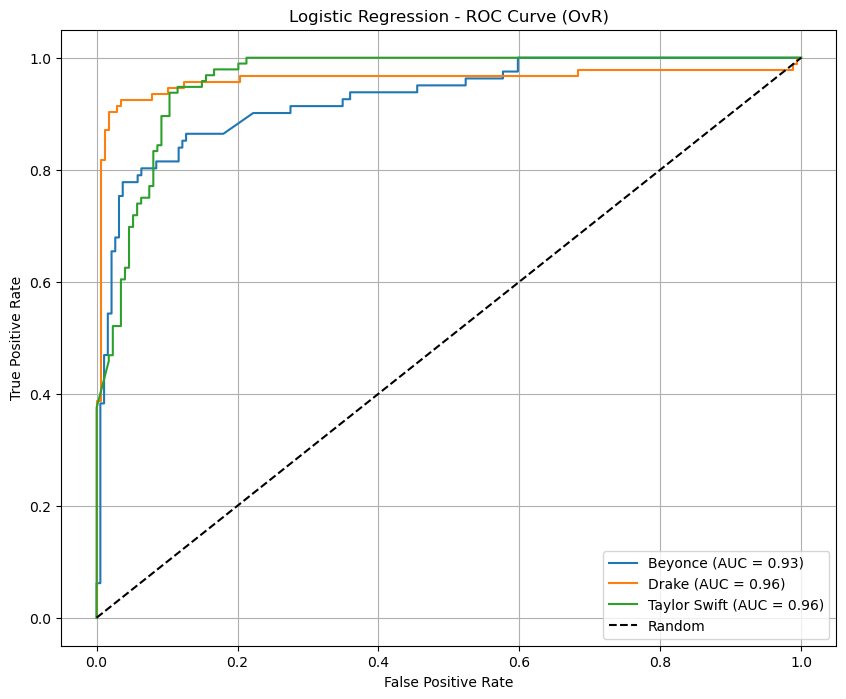


SVM Evaluation
Accuracy: 0.8703703703703703
              precision    recall  f1-score   support

     Beyonce       0.85      0.81      0.83        81
       Drake       0.95      0.89      0.92        93
Taylor Swift       0.82      0.90      0.86        96

    accuracy                           0.87       270
   macro avg       0.87      0.87      0.87       270
weighted avg       0.87      0.87      0.87       270



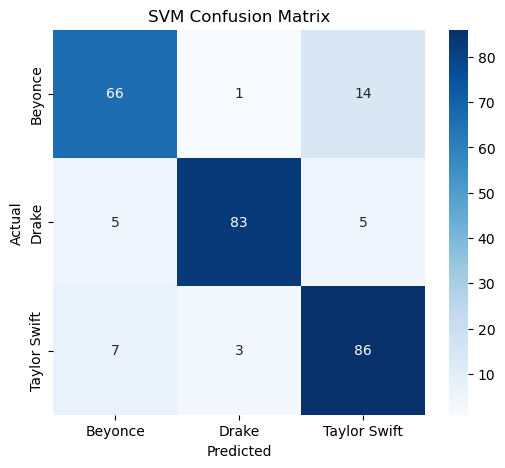

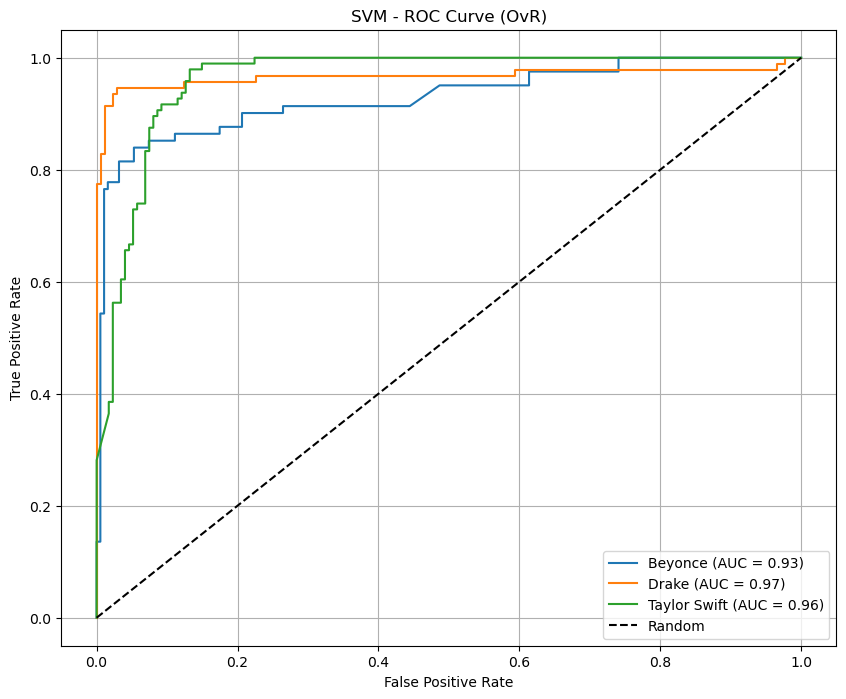


Random Forest Evaluation
Accuracy: 0.8814814814814815
              precision    recall  f1-score   support

     Beyonce       0.89      0.78      0.83        81
       Drake       0.90      0.90      0.90        93
Taylor Swift       0.86      0.95      0.90        96

    accuracy                           0.88       270
   macro avg       0.88      0.88      0.88       270
weighted avg       0.88      0.88      0.88       270



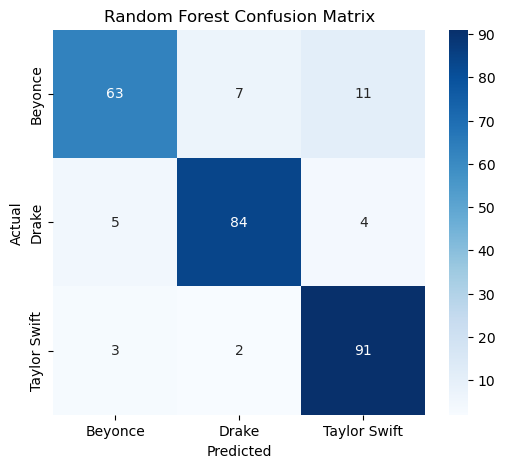

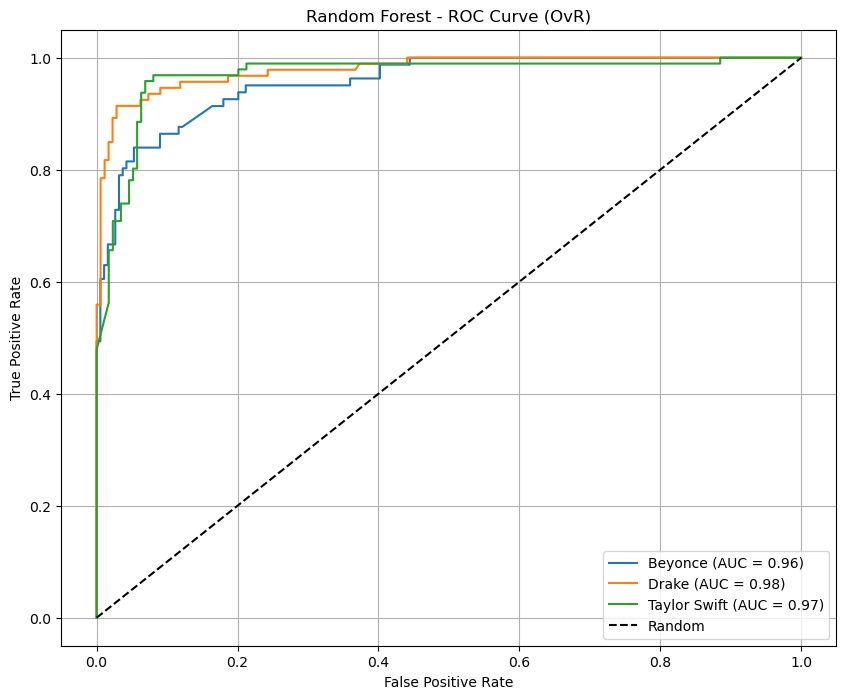


Naive Bayes Evaluation
Accuracy: 0.837037037037037
              precision    recall  f1-score   support

     Beyonce       0.98      0.60      0.75        81
       Drake       0.84      0.94      0.88        93
Taylor Swift       0.78      0.94      0.85        96

    accuracy                           0.84       270
   macro avg       0.86      0.83      0.83       270
weighted avg       0.86      0.84      0.83       270



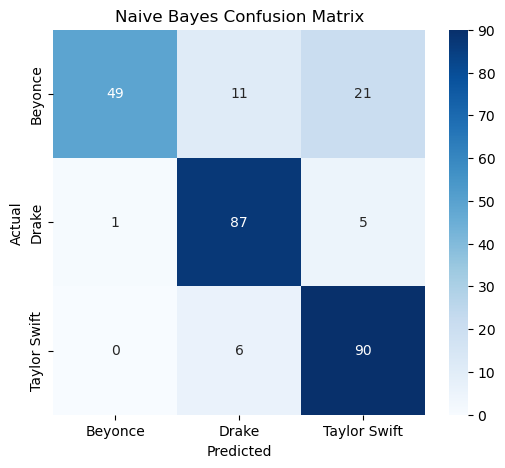

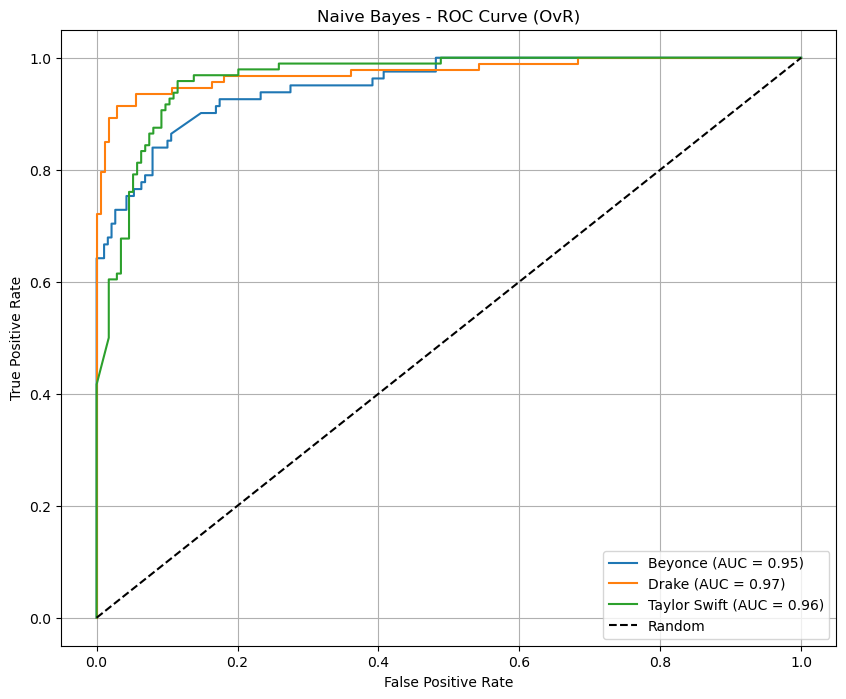

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Store class names for later use
class_names = le.classes_

# Updated evaluation function for binary case
def evaluate_model_with_roc(model, name):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve for multi-class using One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_vec, y_train)
    y_score = clf.predict_proba(X_test_vec)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve (OvR)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Evaluate models with full visuals
evaluate_model_with_roc(LogisticRegression(max_iter=1000), "Logistic Regression")
evaluate_model_with_roc(SVC(kernel='linear', probability=True), "SVM")
evaluate_model_with_roc(RandomForestClassifier(n_estimators=100), "Random Forest")
evaluate_model_with_roc(MultinomialNB(), "Naive Bayes")

In [76]:
# Get the total number of records in the combined and cleaned dataset
total_records = len(df)
total_records

1347